# Notebook #2

## Dataset Preprocessing Notebook

Opens the fits files using data_loader and filter the dataset using the catalog standardizer, then Saves the cleaned datasets in gzip files

### Import Statements and Load config.yaml file

In [17]:
import sys
sys.path.append("./utils")

import pandas             as pd
import numpy              as np
import matplotlib.pyplot  as plt
from astropy.io           import fits

from catalog_standardizer import CatalogStandardizer
from config_loader        import ConfigLoader
from data_loader          import DataLoader

In [18]:
config = ConfigLoader("/Users/admin/Documents/GitHub/Matched-Catalog-Analysis/src/configs/config.yaml")
data = DataLoader(verbose=0)


plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana']
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['legend.fontsize'] = 16

edff_color = '#e46868'
erosita_color = '#3d7cdc'
cdfs_color = '#6ead50'

df_eROSITA = data.get_dataframe(config.EROSITA_PATH)
df_edff = data.get_dataframe(config.EDFF_PATH)
df_cdfs = data.get_dataframe(config.CDFS_PATH)

### Initialize RA and DEC of Catalogs

In [19]:
df_eROSITA_RA, df_eROSITA_DEC = df_eROSITA['RA_RAW'], df_eROSITA['DEC_RAW']
df_edff_RA, df_edff_DEC = df_edff['ALPHA_J2000'], df_edff['DELTA_J2000']
df_cdfs_RA, df_cdfs_DEC = df_cdfs['RAJ2000'], df_cdfs['DEJ2000']

## RA and DEC Plots

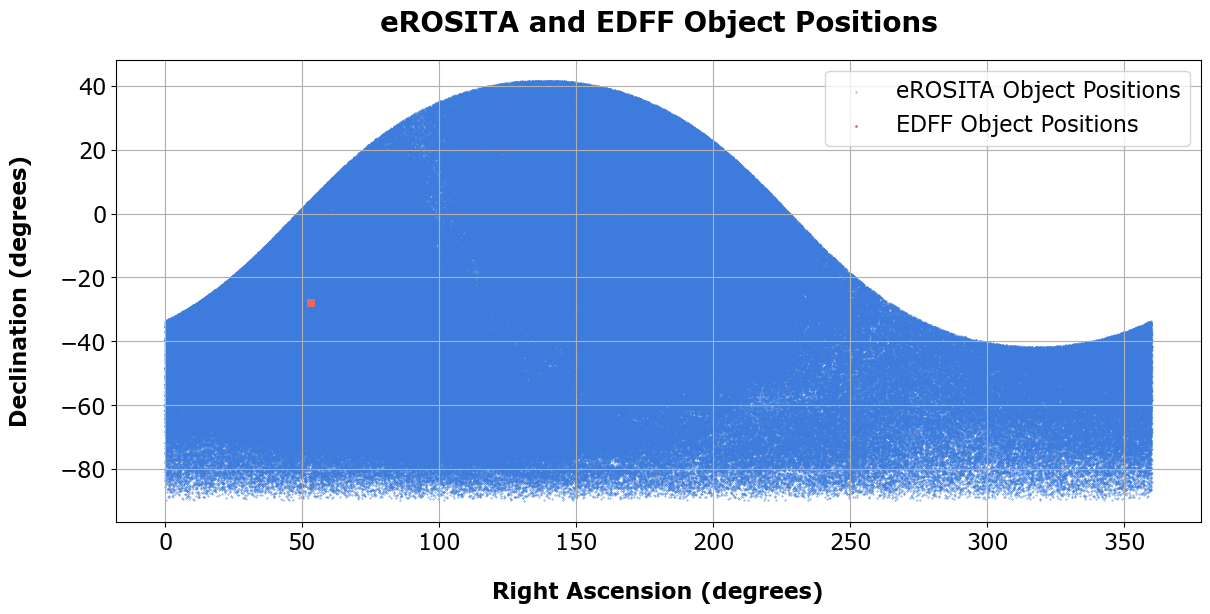

In [20]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.scatter(df_eROSITA_RA, df_eROSITA_DEC, c=erosita_color, s=0.1, label='eROSITA Object Positions')
ax.scatter(df_edff_RA, df_edff_DEC, c=edff_color, s=1, label='EDFF Object Positions')

ax.set_title('eROSITA and EDFF Object Positions')
ax.set_xlabel('Right Ascension (degrees)')
ax.set_ylabel('Declination (degrees)')
ax.grid(True)
ax.legend()

plt.savefig('plots/erosita_h20_fields.png')
plt.show()

EDFF: 1062645 eROSITA: 221 CDFS: 1055


/var/folders/c5/twz9894d7cddf4j0xlk4n7cm0000gn/T/ipykernel_71498/3599371853.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('plots/all_fields.png')


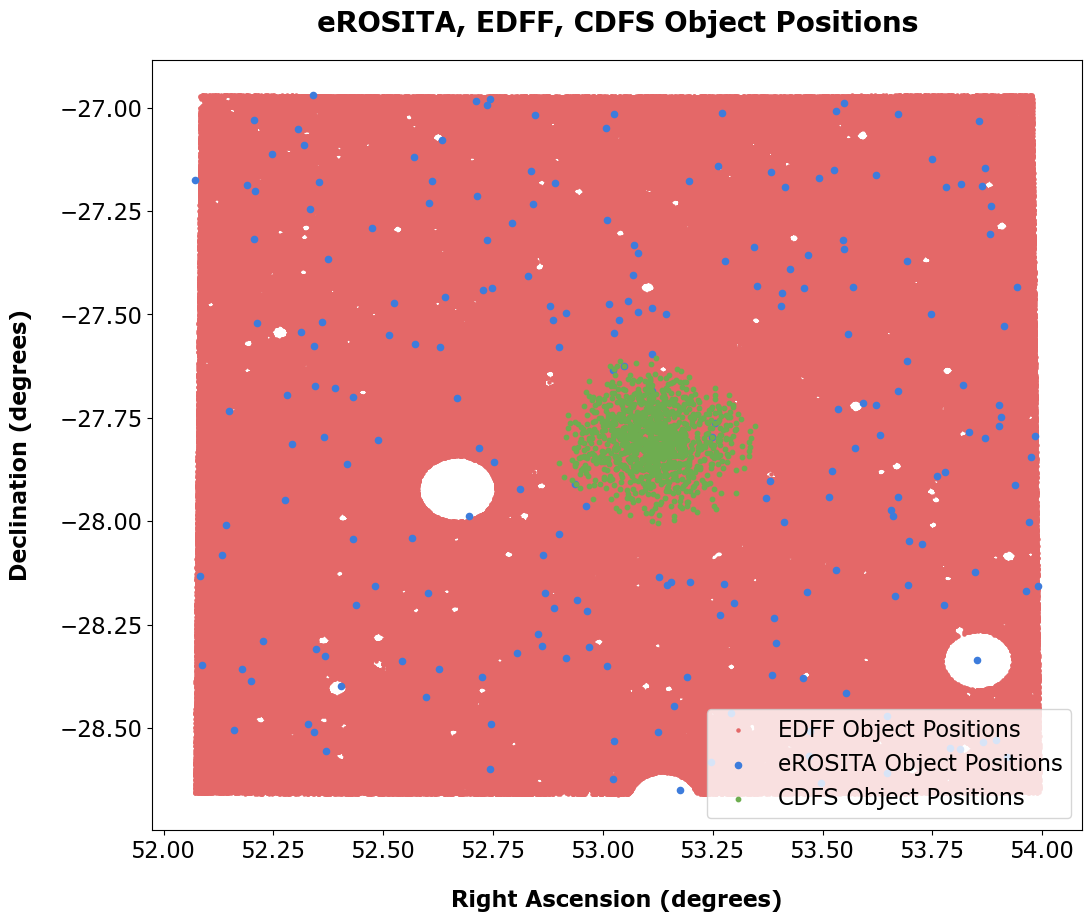

In [25]:
min_RA = max(df_eROSITA_RA.min(), df_edff_RA.min())
max_RA = min(df_eROSITA_RA.max(), df_edff_RA.max())
min_DEC = max(df_eROSITA_DEC.min(), df_edff_DEC.min())
max_DEC = min(df_eROSITA_DEC.max(), df_edff_DEC.max())


filtered_eROSITA = df_eROSITA[
    (df_eROSITA_RA >= min_RA) & (df_eROSITA_RA <= max_RA) &
    (df_eROSITA_DEC >= min_DEC) & (df_eROSITA_DEC <= max_DEC)
]

filtered_edff = df_edff[
    (df_edff_RA >= min_RA) & (df_edff_RA <= max_RA) &
    (df_edff_DEC >= min_DEC) & (df_edff_DEC <= max_DEC)
]

filtered_eROSITA_RA, filtered_eROSITA_DEC = filtered_eROSITA['RA_RAW'], filtered_eROSITA['DEC_RAW']
filtered_edff_RA, filtered_edff_DEC = filtered_edff['ALPHA_J2000'], filtered_edff['DELTA_J2000']

print(f"EDFF: {len(filtered_edff)} eROSITA: {len(filtered_eROSITA)} CDFS: {len(df_cdfs)}")

fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(filtered_edff_RA, filtered_edff_DEC, c=edff_color, s=5, label='EDFF Object Positions')
ax.scatter(filtered_eROSITA_RA, filtered_eROSITA_DEC, c=erosita_color, s=20, label='eROSITA Object Positions')
ax.scatter(df_cdfs_RA, df_cdfs_DEC, c=cdfs_color, s=10, label='CDFS Object Positions')

ax.set_title('eROSITA, EDFF, CDFS Object Positions')
ax.set_xlabel('Right Ascension (degrees)')
ax.set_ylabel('Declination (degrees)')
ax.legend()
ax.grid(False)

plt.savefig('plots/all_fields.png')
plt.show()

## Catalog Standardization

Filter the eROSITA dataset so that only the objects in the edff regions are included

In [22]:
eROSITA_standardizer = CatalogStandardizer(
    df_eROSITA['RA'],
    df_eROSITA['DEC'],
    df_eROSITA["POS_ERR"],
    df_eROSITA["POS_ERR"],
    df_eROSITA["ML_FLUX_1"],
)

edff_standardizer = CatalogStandardizer(
    df_edff['ALPHA_J2000'],
    df_edff['DELTA_J2000'],
    df_edff['ERRX_MODEL'],
    df_edff['ERRY_MODEL'],
    df_edff['CFHT_u_MAG'],
)

cdfs_standardizer = CatalogStandardizer(
    df_cdfs['RAJ2000'],
    df_cdfs['DEJ2000'],
    df_cdfs['errPos'],
    df_cdfs['errPos'],
    df_cdfs['FB'],
)   

edff_standardized = edff_standardizer.standardize()
eROSITA_standardized = eROSITA_standardizer.standardize()
cdfs_standardized = cdfs_standardizer.standardize()

min_RA = max(edff_standardized['ra'].min(), eROSITA_standardized['ra'].min())
max_RA = min(edff_standardized['ra'].max(), eROSITA_standardized['ra'].max())
min_DEC = max(edff_standardized['dec'].min(), eROSITA_standardized['dec'].min())
max_DEC = min(edff_standardized['dec'].max(), eROSITA_standardized['dec'].max())

edff_standardized = edff_standardized[
    (edff_standardized['ra'] >= min_RA) & (edff_standardized['ra'] <= max_RA) &
    (edff_standardized['dec'] >= min_DEC) & (edff_standardized['dec'] <= max_DEC)
].reset_index(drop=True)

eROSITA_standardized = eROSITA_standardized[
    (eROSITA_standardized['ra'] >= min_RA) & (eROSITA_standardized['ra'] <= max_RA) &
    (eROSITA_standardized['dec'] >= min_DEC) & (eROSITA_standardized['dec'] <= max_DEC)
].reset_index(drop=True)

In [23]:
eROSITA_standardized.to_csv(f"{config.INPUT_CATALOG_PATH}/erosita_LYR.csv", sep=",", index=False)
cdfs_standardized.to_csv(f"{config.INPUT_CATALOG_PATH}/cdfs_LYR.csv", sep=",", index=False)
edff_standardized.to_csv(f"{config.INPUT_CATALOG_PATH}/edff_LYR.csv", sep=",", index=False)